In [87]:
import pandas as pd 
import numpy as np
import scipy
import io

In [88]:
data_path = "/Users/anasouza/ppgeb_masters/data/tempo_piscada/teste_piscada_4seg-1.txt"

# Ler o dataset

In [89]:
def read_dataset(data_path):
    data_list = []
    with io.open(data_path, mode="r", encoding="utf-8") as f:
        for line in f:
            data_list.append(line.rstrip().split())
    return data_list

In [90]:
piscada1 = read_dataset(data_path)

# Limpar o dataset

In [91]:

def replace_blink_values(val):
    if val != "0":
        x = "200"
    else:
        x = "0"
    return str(x)

def blink_et(val):
    if val != 0:
        return "BLINK 500"
    if val == 0:
        return str(val)

def identificar_blink_eeg(val):
    try: 
        x = int(val)
        if x > 150:
            return str(500)
        else:
            return str(val)
    except:
        return str(val)


def clean_dataset(data_list):
    df = pd.DataFrame(data_list)
    df.columns=df.iloc[0] 
    df = df.iloc[1:]
    df.iloc[-1,-1] = df.iloc[-1,3]
    df.USER = df.USER.replace("START_RECORDING", "START_RECORDING 100").replace("STOP_EYETRACKER", "STOP_EYETRACKER 200")
    df = df.loc[df["USER"] != "CLIENT2_READY"]

    eeg = df.iloc[:,[2,-1]]
    et = df.iloc[:,:-1]

    et["BKID"] = et.BKID.apply(replace_blink_values)
    eeg['USER'] = eeg.USER.apply(identificar_blink_eeg)
    et["USER"] = et.BKID.apply(blink_et)

    et["BKID"] = et["BKID"].astype("object")
    et["USER"] = et["USER"].astype("object")
    eeg["USER"] = eeg["USER"].astype("object")

    return df, eeg, et

In [92]:
df, eeg, et = clean_dataset(piscada1)

/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_1153/4110602697.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_1153/4110602697.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_1153/4110602697.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [59]:
df.TIME.astype(float).min()/100, df.TIME.astype(float).max()/100

(3.8690283, 4.0829974)

# Plotar antes de Filtrar

In [94]:
import plotly.express as px
import numpy as np

def plot_time_series_eeg(df):
    df_plot = df.loc[df["USER"] != "START_RECORDING 100"]
    df_plot = df_plot.loc[df["USER"] != "STOP_EYETRACKER 200"]
    df_plot = df_plot.loc[df["USER"].notnull()]
    df_plot.USER = df_plot.USER.astype(int)
    df_plot.BKID = df_plot.BKID.astype(int)
    df_plot.TIME = df_plot.TIME.astype(float)
    df_plot.BKID = np.where(df_plot.BKID != 0, 500, df_plot.BKID)
    fig = px.line(df_plot, x='TIME', y="USER")
    fig.add_scatter(x=df_plot['TIME'], y=df_plot['BKID'], mode='lines')
    fig.show()

In [95]:
plot_time_series_eeg(df)

# Filtrar o EEG

In [96]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [97]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 60
lowcut = 1
highcut = 20

In [98]:
df = df.dropna()

In [99]:
df_USER_numeric = df.loc[df["USER"].str.isnumeric()]

In [100]:
df_USER_numeric["USER"] = df_USER_numeric["USER"].astype(float)

/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_1153/623918702.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
df_USER = df_USER_numeric["USER"].values

In [102]:
band_filtered = butter_bandpass_filter(df_USER, lowcut, highcut, fs )

In [158]:
df_plot = pd.DataFrame(band_filtered)

In [104]:
df_plot.columns = ["USER"]
df_plot["TIME"] = df_USER_numeric.TIME.astype(float)

In [143]:
def plot_time_series_eeg_filtered(df_plot, df):
    fig = px.line(df_plot, y="USER")
    df['TIME'] = df['TIME'].astype(float)
    fig.add_scatter(x=df['TIME'], y=df['BKID'], mode='lines')
    fig.show()

In [144]:
plot_time_series_eeg(df)

In [145]:
plot_time_series_eeg_filtered(df_plot, df)

/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_1153/2173813683.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
def plot_time_series_eeg_filtered(df_plot, df, lag=0):
    fig = px.line(df_plot, y="USER")
    fig.add_scatter(x=df['TIME'], y=df['BKID'], mode='lines')
    fig.show()

In [120]:
 plot_time_series_eeg_filtered(df_plot, df, lag=0)

In [115]:
def plot_time_series_eeg_filtered(df_plot, df, lag=1):
    fig = px.line(df_plot, y="USER")
    df_plot['TIME'] = df_plot['TIME'].astype(float)
    df_plot['TIME'] = df_plot['TIME']
    fig.add_scatter(x=df['TIME'], y=df['BKID'], mode='lines')
    fig.show()

In [116]:
plot_time_series_eeg_filtered(df_plot, df, lag=0)

In [75]:
df_plot

,USER,TIME
0,6.590611,NaN
1,26.836460,NaN
2,37.348603,NaN
3,16.940849,NaN
4,-1.203962,NaN
...,...,...
918,2.455575,396.92435
919,41.938333,NaN
920,-1.680816,NaN
921,-10.793866,NaN


In [ ]:
def plot_time_series_eeg_filtered(df, df_plot):
    df_plot = df.loc[df["USER"] != "START_RECORDING 100"]
    df_plot = df_plot.loc[df["USER"] != "STOP_EYETRACKER 200"]
    df_plot = df_plot.loc[df["USER"].notnull()]
    df_plot.USER = df_plot.USER.astype(int)
    df_plot.BKID = df_plot.BKID.astype(int)
    df_plot.TIME = df_plot.TIME.astype(float)
    df_plot.BKID = np.where(df_plot.BKID != 0, 500, df_plot.BKID)
    fig = px.line(df_plot, x='TIME', y="USER")
    fig.add_scatter(x=df_plot['TIME'], y=df_plot['BKID'], mode='lines')
    fig.show()

In [73]:
plot_time_series_eeg_filtered(df_plot)

In [26]:
df_plot["USER"].mean()

-0.24207401823883257

In [27]:
mean = df_plot["USER"].mean()
std = np.std(df_plot["USER"].values)
print('mean of the dataset is', mean)
print('std. deviation is', std)

mean of the dataset is -0.24207401823883257
std. deviation is 82.00037254946841


In [28]:
threshold = 1.5
outlier = []
for i in df_plot["USER"].values:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [198.49702944165307, 376.73816619317876, 277.65038719804625, 129.35711246638093, 128.98031269201803, 287.3228580228296, 541.9478493849565, 381.16784904877693, 135.11920807068338, 139.16900988119616, 144.7473129851029, 172.55359371464766, 129.21699084738867, 126.13123702162892, 129.02045330103334, 219.5551673625701, 420.27376300707203, 315.7471313144405, 147.08000118183023, 126.06186534831352, 132.39756313333191, 208.64841176976273, 453.4024091724495, 309.65520557284896, 131.28019359721446, 136.86024918959555, 230.48922465354593, 475.0459864853152, 216.0999326874896, 132.099676021244, 134.42744963854992]


In [29]:
def is_outlier(val):
    if val in outlier:
        return 500
    else:
        return 0

In [30]:
df_plot["OUTLIER"] = df_plot["USER"].apply(is_outlier)

In [33]:
df_plot

,USER,TIME,OUTLIER
0,6.590611,NaN,0
1,26.836460,NaN,0
2,37.348603,NaN,0
3,16.940849,NaN,0
4,-1.203962,NaN,0
...,...,...,...
918,2.455575,396.92435,0
919,41.938333,NaN,0
920,-1.680816,NaN,0
921,-10.793866,NaN,0


In [31]:

def plot_time_series_eeg(df):
    df_plot.TIME = df_plot.TIME.astype(float)
    fig = px.line(df_plot, y="USER", color="OUTLIER")
    px.line(df_plot, x='Date', y='value', color='AAPL' )
    fig.show()

In [32]:
plot_time_series_eeg(df_plot)

In [30]:
def ident_row(row):
    if row["OUTLIER"] == 500:
         row["TIME"] 

In [31]:
df_plot.loc[df_plot["OUTLIER"] != 0]

,USER,TIME,OUTLIER
176,198.497029,389.64661,500
177,376.738166,389.66296,500
178,277.650387,389.67935,500
196,129.357112,389.90948,500
200,128.980313,389.97513,500
299,287.322858,NaN,500
300,541.947849,391.42148,500
301,381.167849,NaN,500
321,135.119208,391.60321,500
322,139.169010,NaN,500


# Area Under the Curve Between Two Vectors 

In [147]:
plot_time_series_eeg(df)

In [148]:
df_plot

,USER,TIME
0,6.590611,NaN
1,26.836460,NaN
2,37.348603,NaN
3,16.940849,NaN
4,-1.203962,NaN
...,...,...
918,2.455575,396.92435
919,41.938333,NaN
920,-1.680816,NaN
921,-10.793866,NaN


In [150]:
df = df.loc[df["USER"] != "START_RECORDING 100"]
df = df.loc[df["USER"] != "STOP_EYETRACKER 200"]
df = df.loc[df["USER"].notnull()]
df.USER = df.USER.astype(int)
df.BKID = df.BKID.astype(int)
df.TIME = df.TIME.astype(float)
df.BKID = np.where(df.BKID != 0, 500, df.BKID)

In [154]:
mean = df["USER"].mean()
std = np.std(df["USER"].values)

threshold = 1.5
outlier = []
for i in df["USER"].values:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [401, 585, 677, 359, 359, 359, 363, 508, 828, 857, 621, 279, 264, 278, 394, 752, 706, 688, 317, 490, 771, 792, 491, 285, 371, 868, 453, 269, 329]


In [155]:
df["OUTLIER"] = df["USER"].apply(is_outlier)

In [156]:
df

,DATATYPE,CNT,TIME,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,...,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,BKID,BKDUR,BKPMIN,USER,OUTLIER
87,SMP,22969,388.28348,0.35460,0.36120,11.03796,1.00348,1,0.71080,0.38681,...,0.03503,0.01085,0.60279,0.00426,1,0,0.00000,30,49,0
88,SMP,22970,388.30334,0.35421,0.36127,10.79699,1.00348,1,0.71230,0.38170,...,0.03503,0.01085,0.60279,0.00285,1,0,0.00000,30,49,0
89,SMP,22971,388.32071,0.35384,0.36135,10.57843,1.00348,1,0.71187,0.38181,...,0.03489,0.01084,0.60238,0.00305,1,0,0.00000,30,49,0
90,SMP,22972,388.33209,0.35381,0.36125,10.05220,1.00348,1,0.71199,0.38177,...,0.03489,0.01084,0.60238,0.00294,1,0,0.00000,30,49,0
92,SMP,22973,388.35349,0.35335,0.36187,10.81023,1.00348,1,0.71179,0.38139,...,0.03489,0.01084,0.60238,0.00286,1,0,0.00000,30,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,SMP,24146,408.21225,0.32422,0.36051,10.57380,1.01980,1,0.68361,0.37741,...,0.03285,0.01214,0.63156,0.00390,1,0,0.00000,25,107,0
2184,SMP,24147,408.23135,0.32410,0.36066,10.63459,1.02796,1,0.68364,0.37965,...,0.03285,0.01214,0.63156,0.00360,1,0,0.00000,25,107,0
2185,SMP,24148,408.25137,0.32401,0.36062,10.75516,1.03612,1,0.68424,0.37975,...,0.03285,0.01214,0.63156,0.00385,1,0,0.00000,25,107,0
2186,SMP,24149,408.26987,0.32401,0.36050,10.63256,1.03612,1,0.68443,0.37935,...,0.03285,0.01214,0.63156,0.00384,1,0,0.00000,25,107,0


In [157]:
df

,DATATYPE,CNT,TIME,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,...,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,BKID,BKDUR,BKPMIN,USER,OUTLIER
87,SMP,22969,388.28348,0.35460,0.36120,11.03796,1.00348,1,0.71080,0.38681,...,0.03503,0.01085,0.60279,0.00426,1,0,0.00000,30,49,0
88,SMP,22970,388.30334,0.35421,0.36127,10.79699,1.00348,1,0.71230,0.38170,...,0.03503,0.01085,0.60279,0.00285,1,0,0.00000,30,49,0
89,SMP,22971,388.32071,0.35384,0.36135,10.57843,1.00348,1,0.71187,0.38181,...,0.03489,0.01084,0.60238,0.00305,1,0,0.00000,30,49,0
90,SMP,22972,388.33209,0.35381,0.36125,10.05220,1.00348,1,0.71199,0.38177,...,0.03489,0.01084,0.60238,0.00294,1,0,0.00000,30,49,0
92,SMP,22973,388.35349,0.35335,0.36187,10.81023,1.00348,1,0.71179,0.38139,...,0.03489,0.01084,0.60238,0.00286,1,0,0.00000,30,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,SMP,24146,408.21225,0.32422,0.36051,10.57380,1.01980,1,0.68361,0.37741,...,0.03285,0.01214,0.63156,0.00390,1,0,0.00000,25,107,0
2184,SMP,24147,408.23135,0.32410,0.36066,10.63459,1.02796,1,0.68364,0.37965,...,0.03285,0.01214,0.63156,0.00360,1,0,0.00000,25,107,0
2185,SMP,24148,408.25137,0.32401,0.36062,10.75516,1.03612,1,0.68424,0.37975,...,0.03285,0.01214,0.63156,0.00385,1,0,0.00000,25,107,0
2186,SMP,24149,408.26987,0.32401,0.36050,10.63256,1.03612,1,0.68443,0.37935,...,0.03285,0.01214,0.63156,0.00384,1,0,0.00000,25,107,0


In [159]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [160]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 60
lowcut = 1
highcut = 20

In [161]:
df = df.dropna()

In [162]:
band_filtered = butter_bandpass_filter(df["USER"].values, lowcut, highcut, fs )

In [164]:
df["USER_filtered"] = band_filtered

<AxesSubplot:>

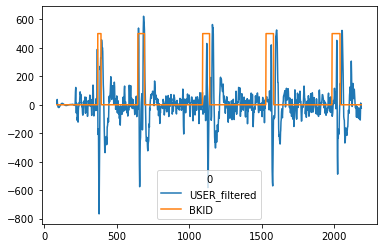

In [169]:
df[["USER_filtered","BKID"]].plot()

In [173]:
df["BKID"].nunique()

2

In [178]:
df

,DATATYPE,CNT,TIME,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,...,REYEY,REYEZ,RPUPILD,RPUPILV,BKID,BKDUR,BKPMIN,USER,OUTLIER,USER_filtered
87,SMP,22969,388.28348,0.35460,0.36120,11.03796,1.00348,1,0.71080,0.38681,...,0.01085,0.60279,0.00426,1,0,0.00000,30,49,0,6.590611
88,SMP,22970,388.30334,0.35421,0.36127,10.79699,1.00348,1,0.71230,0.38170,...,0.01085,0.60279,0.00285,1,0,0.00000,30,49,0,26.836460
89,SMP,22971,388.32071,0.35384,0.36135,10.57843,1.00348,1,0.71187,0.38181,...,0.01084,0.60238,0.00305,1,0,0.00000,30,49,0,37.348603
90,SMP,22972,388.33209,0.35381,0.36125,10.05220,1.00348,1,0.71199,0.38177,...,0.01084,0.60238,0.00294,1,0,0.00000,30,49,0,16.940849
92,SMP,22973,388.35349,0.35335,0.36187,10.81023,1.00348,1,0.71179,0.38139,...,0.01084,0.60238,0.00286,1,0,0.00000,30,48,0,-1.203962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,SMP,24146,408.21225,0.32422,0.36051,10.57380,1.01980,1,0.68361,0.37741,...,0.01214,0.63156,0.00390,1,0,0.00000,25,107,0,12.391665
2184,SMP,24147,408.23135,0.32410,0.36066,10.63459,1.02796,1,0.68364,0.37965,...,0.01214,0.63156,0.00360,1,0,0.00000,25,107,0,0.781241
2185,SMP,24148,408.25137,0.32401,0.36062,10.75516,1.03612,1,0.68424,0.37975,...,0.01214,0.63156,0.00385,1,0,0.00000,25,107,0,-2.163035
2186,SMP,24149,408.26987,0.32401,0.36050,10.63256,1.03612,1,0.68443,0.37935,...,0.01214,0.63156,0.00384,1,0,0.00000,25,107,0,-13.556199


In [180]:
df.TIME = df.TIME.astype(float)
fig = px.line(df, x='TIME', y="USER_filtered")
px.line(df, x='TIME', y='BKID')
fig.add_scatter(x=df['TIME'], y=df['BKID'], mode='lines')
fig.show()

In [181]:
r1 = 392
r2 = 392.25

In [197]:
bk_1 = df[["TIME","USER_filtered","BKID"]]

In [198]:
bk_1 = bk_1.loc[(bk_1["TIME"] >= r1) & (bk_1["TIME"] <= r2)]

In [199]:
window_eeg_blink1 = bk_1

In [190]:
def integrate(x, y):
   sm = 0
   for i in range(1, len(x)):
       h = x[i] - x[i-1]
       sm += h * (y[i-1] + y[i]) / 2

   return sm

In [191]:
integrate( window_eeg_blink1["USER_filtered"].values,window_eeg_blink1["BKID"].values)

182406.70981336336

In [219]:
bk_2 = df.loc[(df["TIME"] >= r1-0.1) & (df["TIME"] <= r1)]


<AxesSubplot:>

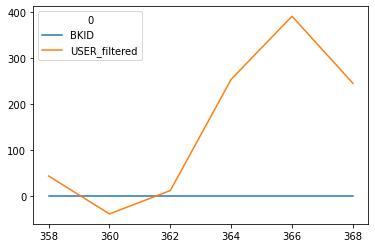

In [218]:
bk_2[["BKID","USER_filtered"]].plot()

In [221]:
integrate( bk_2["USER_filtered"].values,bk_2["BKID"].values +1)

201.4506143954002